# Obtain spatial resolved grain maps of PARADIM-1 in the focus beam

In [35]:
%run -i ../tomography/utils.py

In [2]:
%run -i startup3.py

## Extract the peak positions

### Load and reformat the data

`db_raw` is the databroker database.

In [10]:
sel_row = df_uid.loc[7]
sel_row

uid       d576d21a-d7b6-4539-8c23-0cefa1b1b25c
sample                               PARADIM-1
task                       redo step grid scan
beam                                     focus
Name: 7, dtype: object

In [11]:
run = db_raw[sel_row['uid']]
data = reformat_data(run.xarray_dask())
image_data = data["dexela_image"]

In [12]:
data

<xarray.Dataset>
Dimensions:               (dim_0: 1, dim_1: 3888, dim_2: 3072, frame: 2233)
Coordinates:
  * frame                 (frame) int64 0 1 2 3 4 5 ... 2228 2229 2230 2231 2232
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total   (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image          (frame, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mXBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mXBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [14]:
del sel_row

### Filter the images

We filter the images according to the `dexela_stats1_total` which is the sum of intensity on the image. The powder diffraction image has much higher intensity than the single crystal diffraction image and the air scattering image.

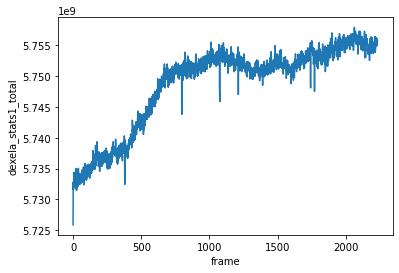

In [15]:
image_sum_data = data['dexela_stats1_total'].compute()
image_sum_data.plot();

If row >= `start_index`, the frames are all from the single crystal diffraction images. We can use the frame index of them to select the valid images.

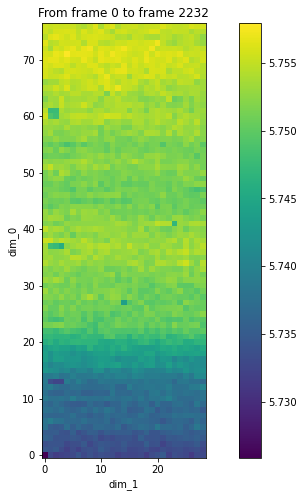

In [20]:
select_frames(image_sum_data / 1e9, run.start, start_row=0)

Filter out the extremely low intensity frames.

In [21]:
sel_image_sum_data = image_sum_data
sel_image_sum_data = sel_image_sum_data[sel_image_sum_data / 1e9 > 5.73]

### Run again with the filtered images

Get the maximum and minimum of pixel values for the images of the non-powder part.

In [25]:
sel_image_data = image_data[sel_image_sum_data.frame.values]
shadows = min_and_max_along_time(sel_image_data)
shadows = shadows.astype(np.int16)

In [26]:
db_cdf.insert(shadows.to_dataset(name="shadow"), dict(**run.start, tag="max and min frame"))

'60c946a528406abaa6991805'

In [27]:
del shadows

### Visualize the averaged light and dark frame

In [28]:
shadows = db_cdf.get_data("60c946a528406abaa6991805")["shadow"]

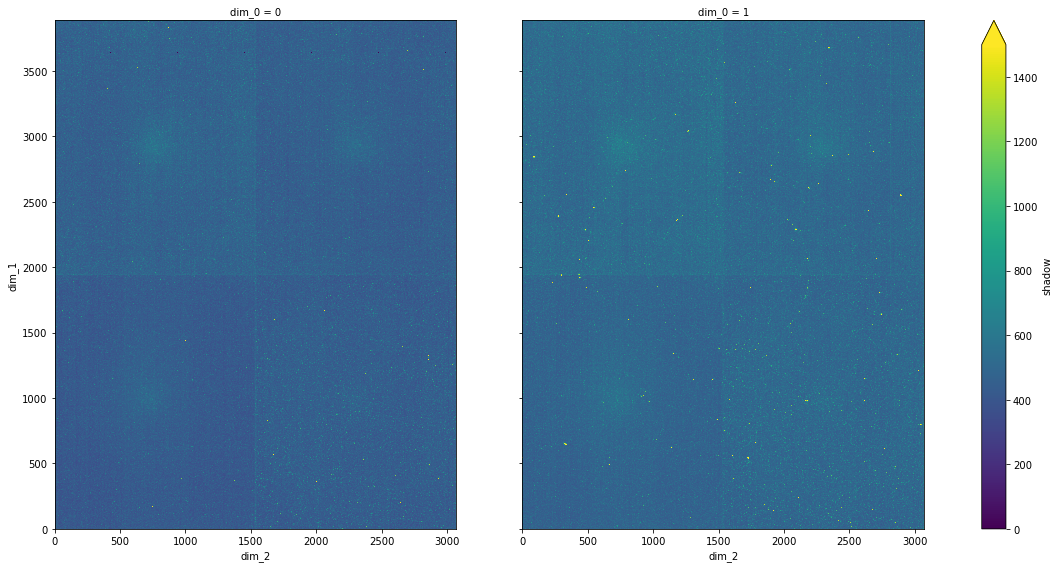

In [29]:
facet = shadows.plot(col="dim_0", size=8, vmax=1500)
set_real_aspect(facet.axes)

The result shows all the shinning points that ever appeared in any of the frames. Some look like Bragg peaks while the other look like a part of powder diffraction rings.

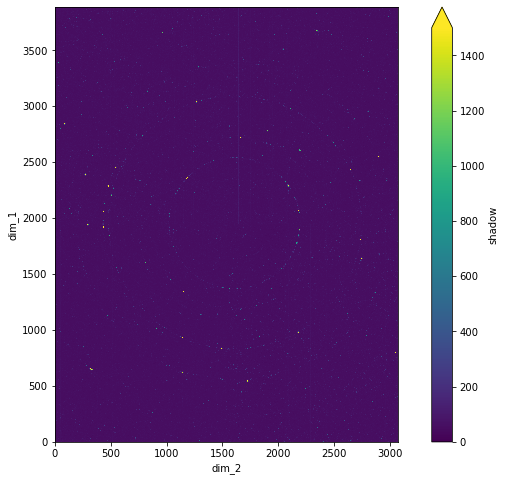

In [30]:
subtracted_shadow = shadows[1] - shadows[0]
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)

## Locate the peak positions and track it

### Locate the spots

Use `trackpy.locate` to find the spots on the image.

In [31]:
df = tp.locate(subtracted_shadow.values, diameter=51, percentile=67., engine="numba", threshold=600, minmass=2000)
df

,y,x,mass,size,ecc,signal,raw_mass,ep
0,62.999729,2374.008899,12015.066574,1.047209,0.258457,2450.242423,129752.0,0.515605
1,68.000037,2521.013543,12665.396521,1.047608,0.259078,2578.077116,129153.0,0.533139
2,126.903213,2169.883442,8087.984808,1.022479,0.294222,1715.309152,122738.0,0.838526
3,143.999273,518.142284,14708.427341,1.108663,0.302350,2800.741909,127666.0,0.582297
4,324.999925,1421.004955,12478.060590,1.046990,0.257689,2547.396790,125729.0,0.661782
...,...,...,...,...,...,...,...,...
74,3505.003351,2630.980824,9017.691666,1.048762,0.258049,1826.409122,119768.0,1.141159
75,3586.777386,1721.997822,7256.362024,0.981540,0.286026,1678.585731,125113.0,0.691814
76,3819.649020,470.995230,19001.813610,1.236558,0.064853,3216.785727,137294.0,0.364618
77,3855.000476,2905.984854,12706.303623,1.048104,0.258792,2580.866237,127450.0,0.590201


In [84]:
db_csv.insert(df, dict(**run.start, tag="located features on the shadow image"))

'60c931f307de20d7d30c65fc'

In [85]:
del df

### Select the ones to track

We select the 20 largest peaks to track.

In [32]:
peaks = db_csv.get_data("60c931f307de20d7d30c65fc")
peaks = peaks.sort_values("mass", ascending=False).iloc[:20]
windows = create_windows_from_width(peaks, 50)

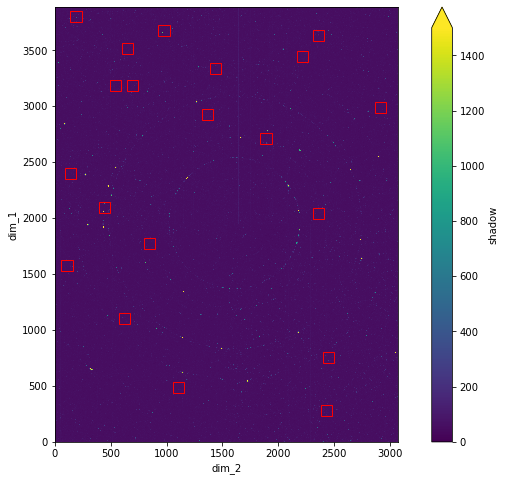

In [33]:
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)
draw_windows(windows, facet.axes)
plt.show()

In [95]:
del facet

### Run the tracking

In [36]:
grains = create_grain_maps(image_data, windows, run.start)

In [38]:
db_cdf.insert(grains, dict(**run.start, tag="grain maps"))

'60ca0e7628406abaa6991806'

In [39]:
del grains

### Visualize the grain maps

This is the final result of 20 grain maps. They are visualized in a log scale color map.

In [40]:
grains = db_cdf.get_data("60ca0e7628406abaa6991806")

In [41]:
grains = grains.set_index({"grain": ["x", "y"]})

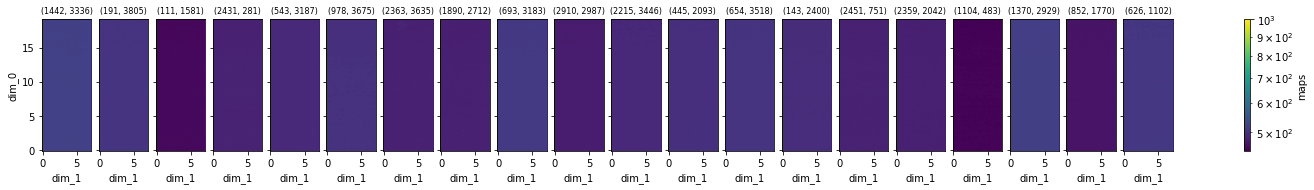

In [42]:
facet = plot_grain_maps(grains, norm=mpl.colors.LogNorm(vmax=1000))
facet.set_titles(template="{value}", size=8);

### The mean of the grain maps

It shows the total distribution of all 20 grains.

In [43]:
mean_map = grains["maps"].mean(axis=2)

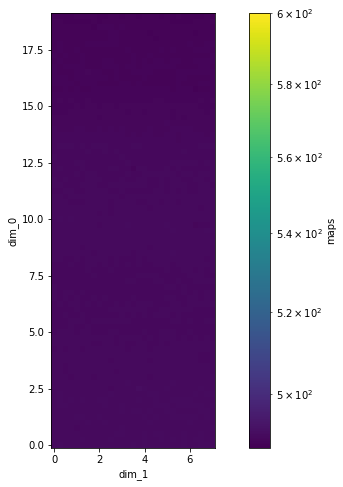

In [44]:
facet = mean_map.plot.pcolormesh(size=8, norm=mpl.colors.LogNorm(vmax=600))
set_real_aspect(facet.axes)